In [58]:
import h5py
import numpy as np
fh5 = h5py.File('d:/h5/fmap_cfl.h5','r')
img = fh5['map']
img = np.array(img)
print(img.shape)
lab = fh5['lab']
lab = np.array(lab)
print(lab.shape)

(11074, 33, 33)
(11074,)


In [59]:
img = img.reshape(len(img), 33, 33, 1)


In [60]:
lll = ['BLCA', 'BRCA', 'CESC', 'COAD', 'ESCA', 'GBM', 'HNSC', 'KIRP','KICH','KIRC', 'LAML', 'LGG', 'LIHC', 'LUAD', 'LUSC',
      'OV', 'PAAD','PRAD','PCPG','READ', 'SARC', 'SKCM', 'STAD', 'TGCT', 'THCA', 'THYM', 'UCEC']

In [61]:
lab

array([ 0.,  0.,  0., ..., 26., 26., 26.])

In [62]:
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(lab)
train_labels.shape

(11074, 27)

In [63]:
train_labels.shape

(11074, 27)

In [65]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(img,train_labels,test_size=0.2,random_state=1)

In [66]:
from keras import models
from keras import layers
from keras.models import Sequential,Input
from keras import optimizers
import keras
from keras.layers import Conv2D,MaxPooling2D,Dropout,BatchNormalization,Flatten,Dense,Lambda,Multiply,AveragePooling2D,Activation
from keras.models import Model

In [67]:
callbacks_list = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=10),
    keras.callbacks.ModelCheckpoint(filepath='e:/data/rmap.h5',monitor='val_loss',save_best_only=True)      ]

In [68]:
def Conv2d_BN(x, nb_filter,kernel_size, padding='valid',strides=(1,1),data_format='channels_last',dilation_rate=(1,1),
              activation='relu',name=None):
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None

    #x = BatchNormalization(name=bn_name)(x)
    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides,data_format='channels_last',activation='relu',
               dilation_rate=dilation_rate,name=conv_name)(x)
    x = BatchNormalization(name=bn_name)(x)
    
    return x

In [143]:
def InceptionB(x,nb_filter):
    branch_1x1_t = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_1x1_t = Conv2d_BN(branch_1x1_t,nb_filter,(1,1), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_1x1_s = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_1x1_s = Activation('sigmoid')(branch_1x1_s)
    branch_1x1_c = keras.layers.Multiply()([branch_1x1_t,branch_1x1_s])
    
    branch_3x3_t = Conv2d_BN(x,nb_filter,(3,3), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    #branch_3x3_t = Conv2d_BN(branch_3x3_t,nb_filter,(3,3), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_3x3_s = Conv2d_BN(x,nb_filter,(3,3), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_3x3_s = Activation('sigmoid')(branch_3x3_s)
    branch_3x3_c = keras.layers.Multiply()([branch_3x3_t,branch_3x3_s])
       
    branch_5x5_t = Conv2d_BN(x,nb_filter,(5,5), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    #branch_5x5_t = Conv2d_BN(branch_5x5_t,nb_filter,(5,5), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_5x5_s = Conv2d_BN(x,nb_filter,(5,5), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_5x5_s = Activation('sigmoid')(branch_5x5_s)
    branch_5x5_c = keras.layers.Multiply()([branch_5x5_t,branch_5x5_s])
    

    x = keras.layers.Concatenate(axis=3)([branch_1x1_c,branch_3x3_c,branch_5x5_c]) #

    return x

In [144]:
def InceptionC(x,nb_filter):
    branch_1x1_t = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_1x1_t = Conv2d_BN(branch_1x1_t,nb_filter,(1,1), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_1x1_s = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_1x1_s = Activation('sigmoid')(branch_1x1_s)
    branch_1x1_c = keras.layers.Multiply()([branch_1x1_t,branch_1x1_s])
    
    branch_3x3_t = Conv2d_BN(x,nb_filter,(3,3), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    #branch_3x3_t = Conv2d_BN(branch_3x3_t,nb_filter,(3,3), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_3x3_s = Conv2d_BN(x,nb_filter,(3,3), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_3x3_s = Activation('sigmoid')(branch_3x3_s)
    branch_3x3_c = keras.layers.Multiply()([branch_3x3_t,branch_3x3_s])
    

    x = keras.layers.Concatenate(axis=3)([branch_1x1_c,branch_3x3_c]) #branch_1x1_c,

    return x

In [191]:
def TestNet(input_shape=None):
    inpt = Input(shape=input_shape)
        x = Conv2d_BN(inpt,32,(1,1),strides=(1,1),padding='same')
    x = Conv2d_BN(x,32,(1,1),strides=(1,1),padding='same')
    x = InceptionB(x,64)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')(x)
    x = InceptionB(x,128)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')(x)
    x = InceptionC(x,256)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')(x)
    x = InceptionC(x,512)
    x = AveragePooling2D(pool_size=(2,2),strides=(2,2),padding='same')(x)
    #x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(128,activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(27,activation='softmax')(x)
    model = Model(inpt,x,name='inception')
    
 
    return model

In [192]:
model = TestNet(input_shape=(33,33,1))
model.summary()

Model: "inception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 33, 33, 1)    0                                            
__________________________________________________________________________________________________
conv2d_357 (Conv2D)             (None, 33, 33, 32)   64          input_15[0][0]                   
__________________________________________________________________________________________________
batch_normalization_357 (BatchN (None, 33, 33, 32)   128         conv2d_357[0][0]                 
__________________________________________________________________________________________________
conv2d_358 (Conv2D)             (None, 33, 33, 32)   1056        batch_normalization_357[0][0]    
__________________________________________________________________________________________

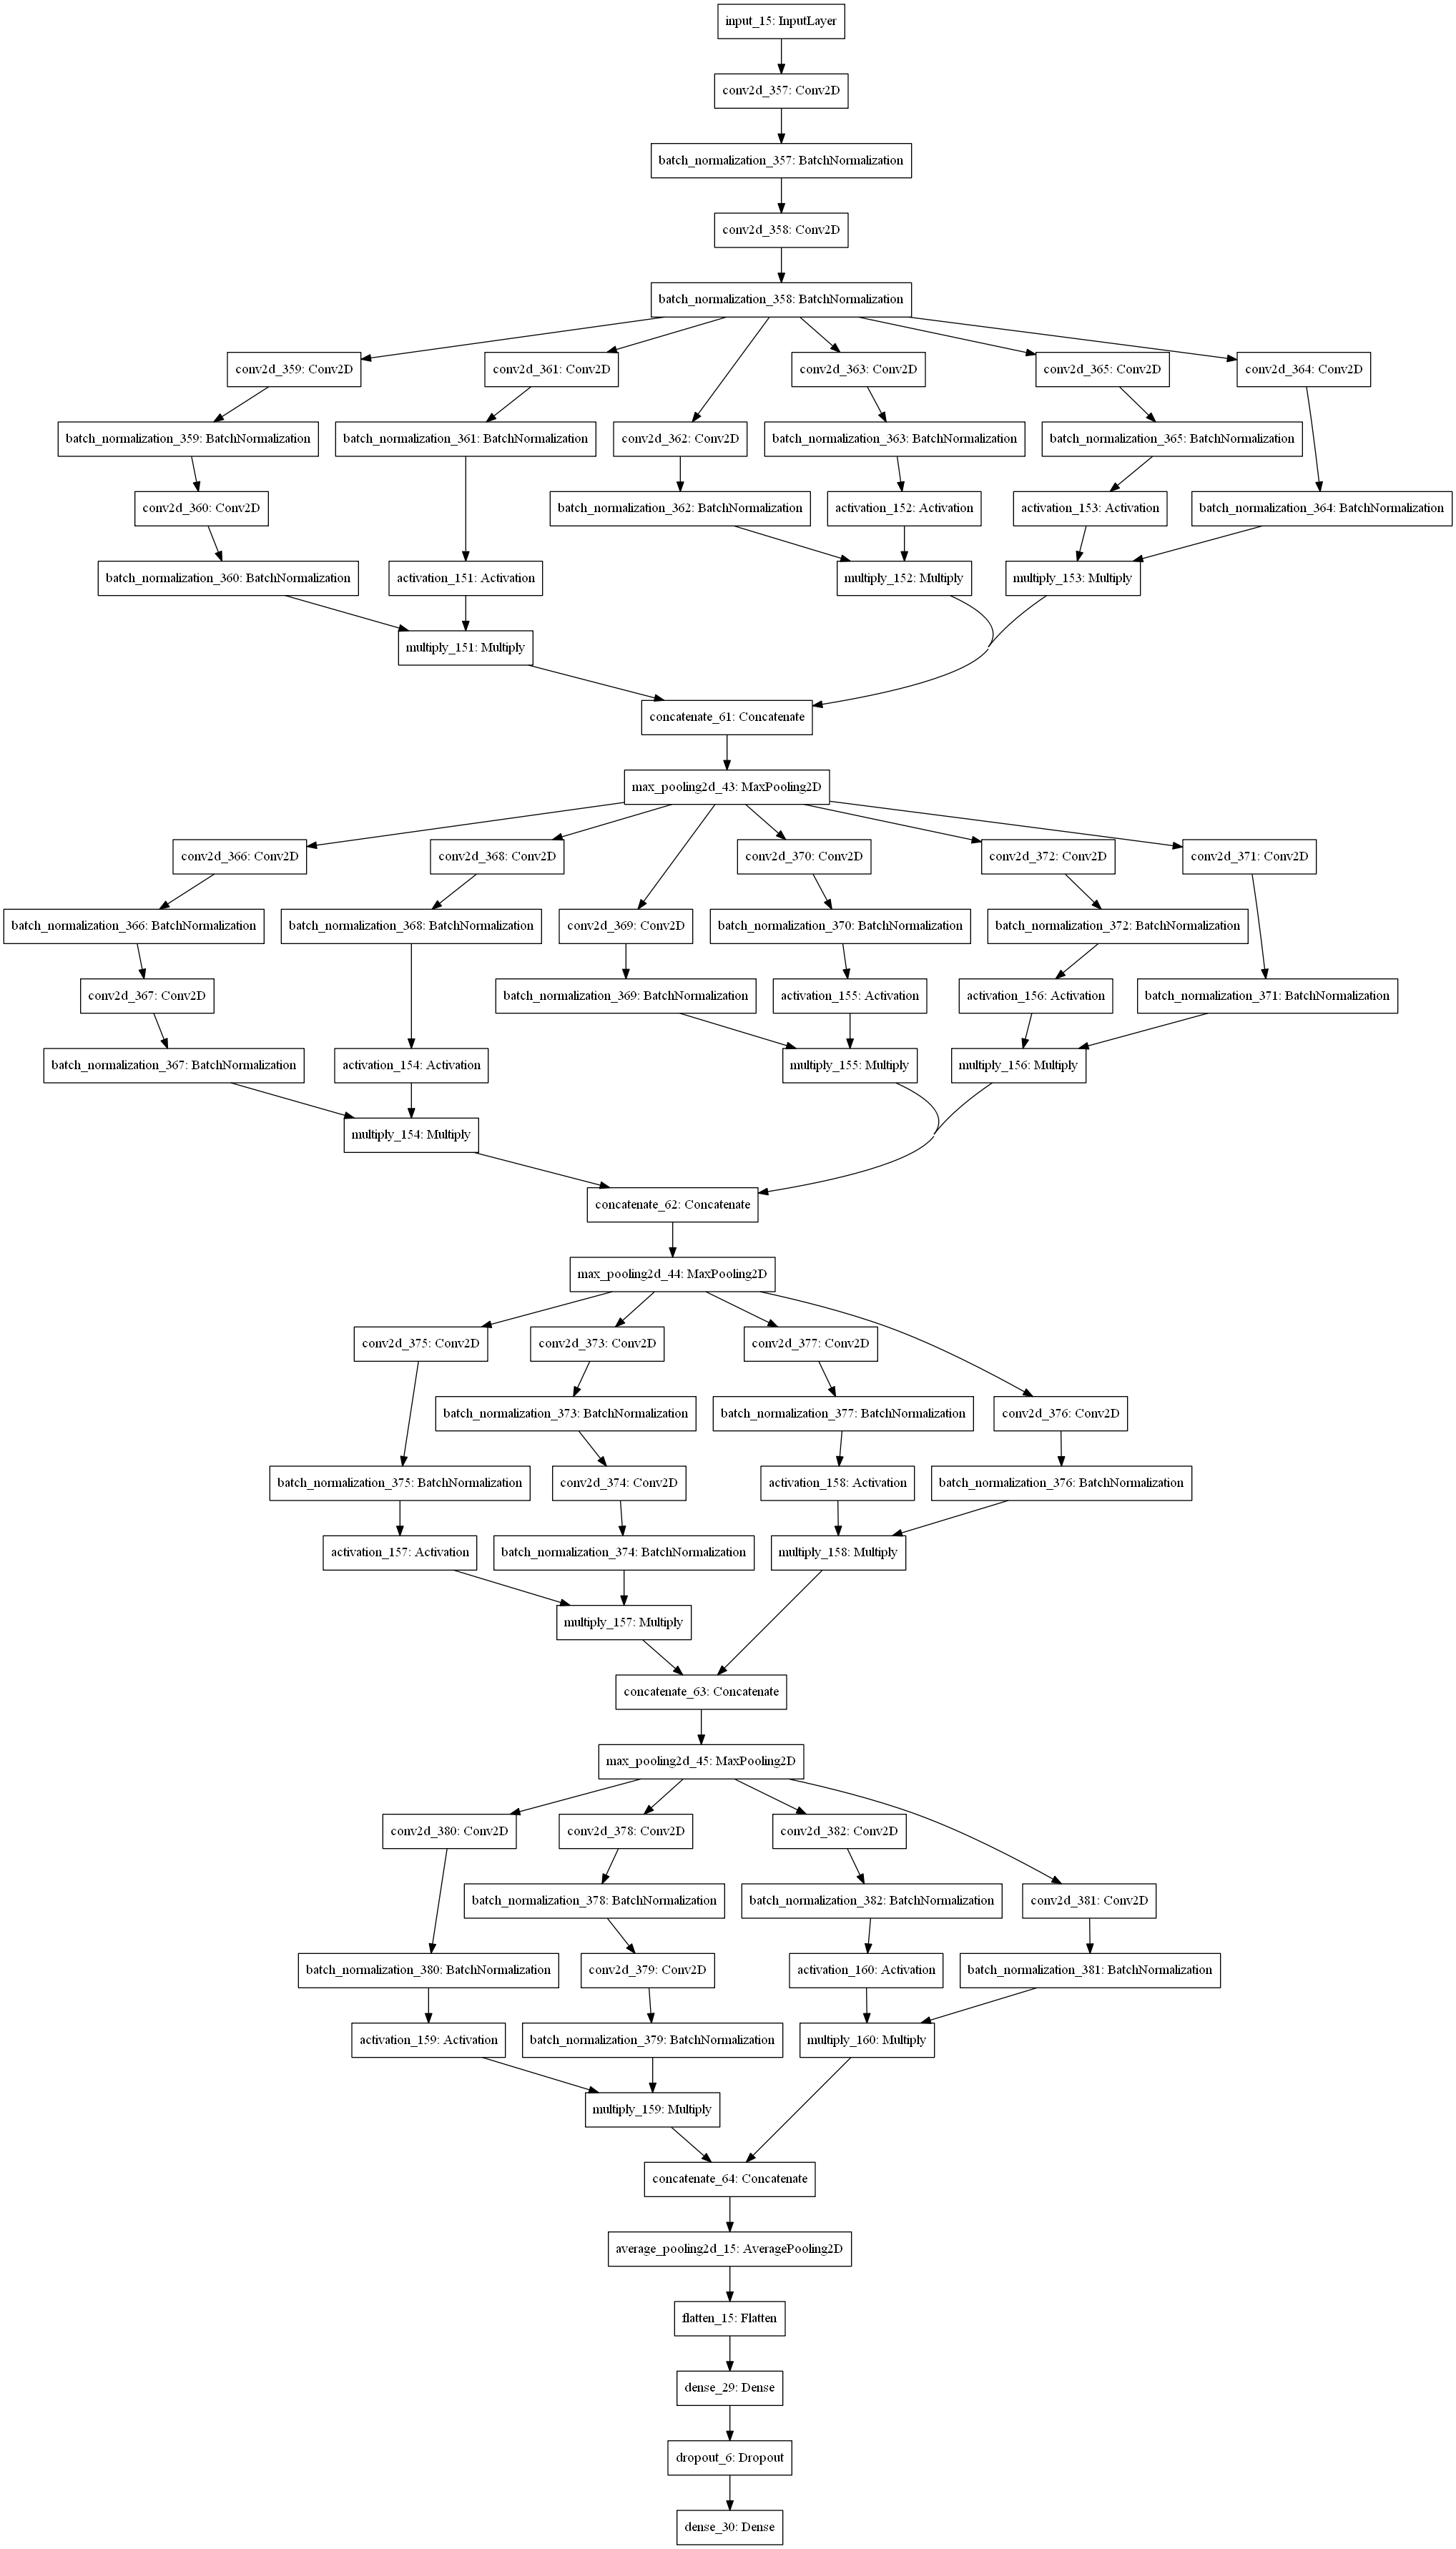

In [193]:
from tensorflow.keras.utils import plot_model     ##模型结构图
plot_model(model, 'd:\\h5\\model_3d.png')

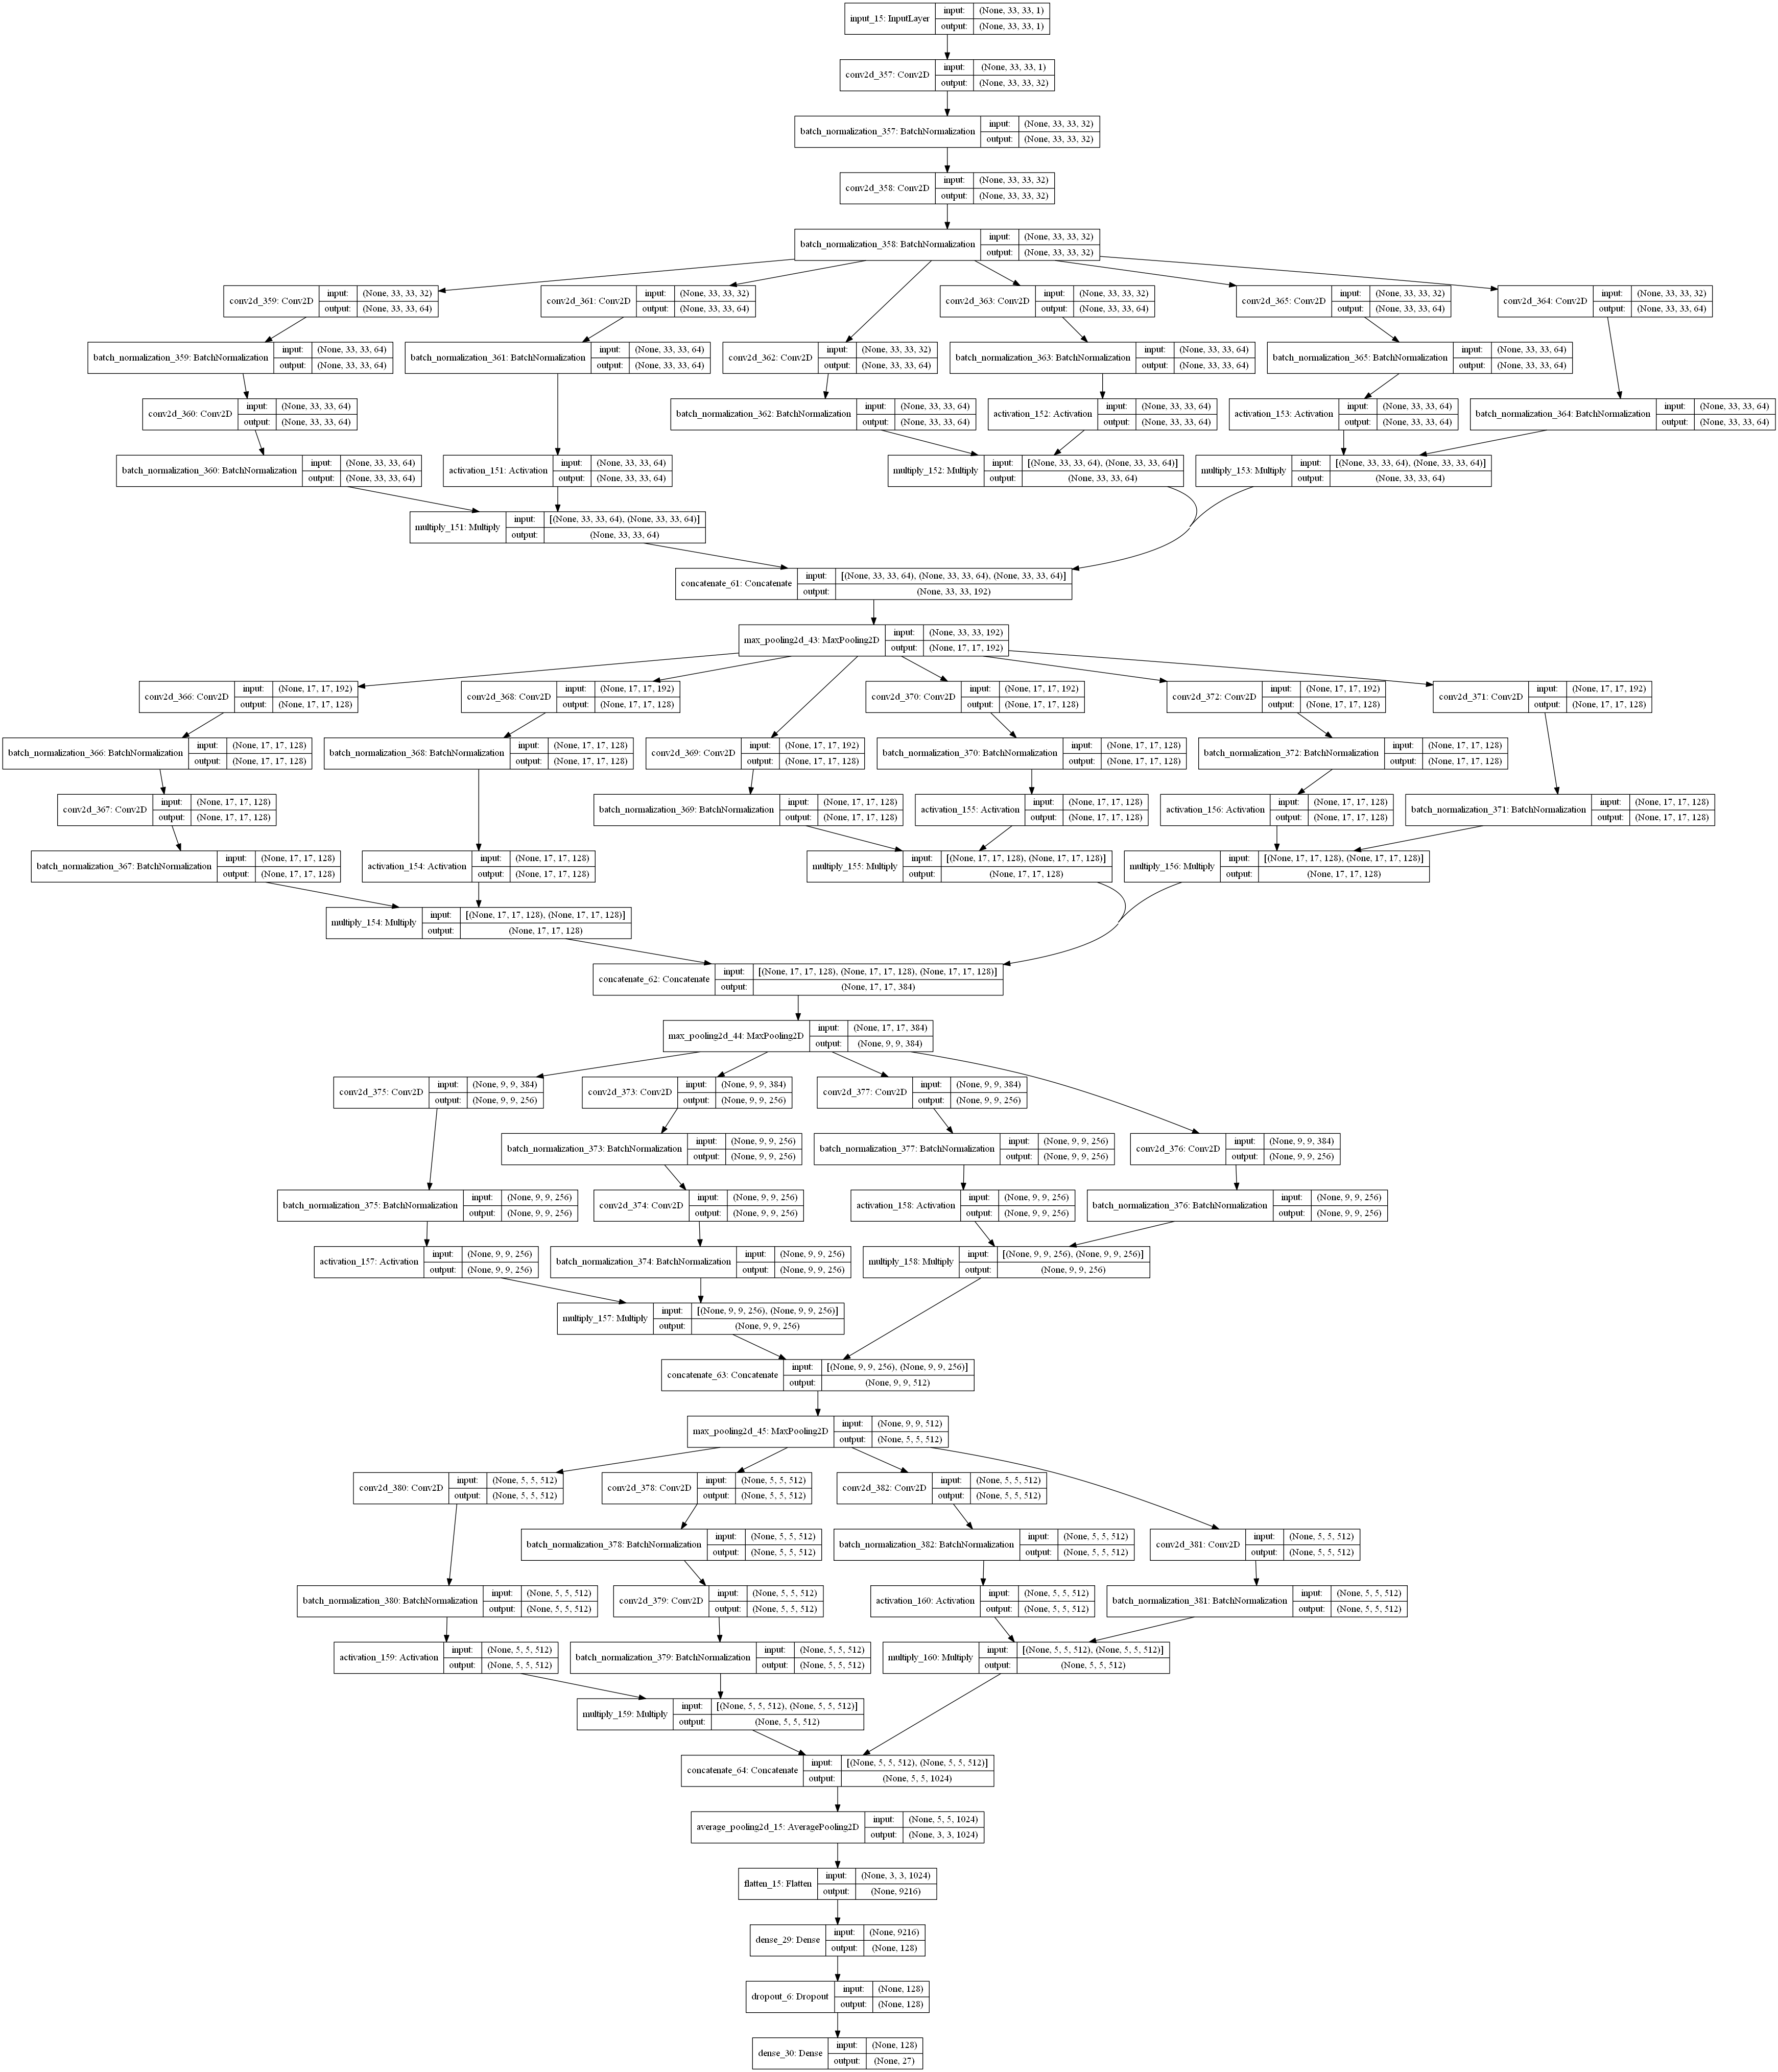

In [194]:
plot_model(model, 'd:\\h5\\model_3d.png',show_shapes=True)

In [195]:
from keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [196]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5),#
              metrics=['acc']
              #metrics=['acc','Precision','Recall'] 
             )

In [197]:
his = model.fit(X_train,y_train,epochs=100,batch_size=256)#,callbacks = callbacks_list,validation_split=0.25

Epoch 1/100
8859/8859 [==============================] - 18s 2ms/step - loss: 2.9314 - acc: 0.2113
Epoch 2/100
8859/8859 [==============================] - 12s 1ms/step - loss: 2.2612 - acc: 0.4619
Epoch 3/100
8859/8859 [==============================] - 11s 1ms/step - loss: 1.7566 - acc: 0.6028
Epoch 4/100
8859/8859 [==============================] - 12s 1ms/step - loss: 1.3619 - acc: 0.6916
Epoch 5/100
8859/8859 [==============================] - 12s 1ms/step - loss: 1.1051 - acc: 0.7512
Epoch 6/100
8859/8859 [==============================] - 12s 1ms/step - loss: 0.9070 - acc: 0.7969
Epoch 7/100
8859/8859 [==============================] - 11s 1ms/step - loss: 0.7743 - acc: 0.8185
Epoch 8/100
8859/8859 [==============================] - 12s 1ms/step - loss: 0.6740 - acc: 0.8415
Epoch 9/100
8859/8859 [==============================] - 11s 1ms/step - loss: 0.5980 - acc: 0.8531
Epoch 10/100
8859/8859 [==============================] - 12s 1ms/step - loss: 0.5296 - acc: 0.8712
Epoch 11/

8859/8859 [==============================] - 12s 1ms/step - loss: 0.0215 - acc: 0.9927
Epoch 84/100
8859/8859 [==============================] - 12s 1ms/step - loss: 0.0190 - acc: 0.9944
Epoch 85/100
8859/8859 [==============================] - 12s 1ms/step - loss: 0.0193 - acc: 0.9938
Epoch 86/100
8859/8859 [==============================] - 12s 1ms/step - loss: 0.0198 - acc: 0.9938
Epoch 87/100
8859/8859 [==============================] - 11s 1ms/step - loss: 0.0197 - acc: 0.9941
Epoch 88/100
8859/8859 [==============================] - 11s 1ms/step - loss: 0.0205 - acc: 0.9933
Epoch 89/100
8859/8859 [==============================] - 12s 1ms/step - loss: 0.0204 - acc: 0.9932
Epoch 90/100
8859/8859 [==============================] - 11s 1ms/step - loss: 0.0175 - acc: 0.9945
Epoch 91/100
8859/8859 [==============================] - 12s 1ms/step - loss: 0.0206 - acc: 0.9935
Epoch 92/100
8859/8859 [==============================] - 12s 1ms/step - loss: 0.0176 - acc: 0.9942
Epoch 93/100


In [198]:
test_loss,test_acc= model.evaluate(X_test,y_test)
print('test_acc:',test_acc)

2215/2215 [==============================] - 4s 2ms/step
test_acc: 0.9060947895050049


In [199]:
predict = model.predict(X_test)
predict=np.argmax(predict,axis=1)

In [200]:
y_test2=np.argmax(y_test,axis=1)

In [201]:
predict.shape

(2215,)

In [202]:
predict

array([26, 26, 22, ..., 26,  3, 21], dtype=int64)

In [204]:
from sklearn.metrics import classification_report
print(classification_report(y_test2,predict,target_names=lll))

              precision    recall  f1-score   support

        BLCA       0.89      0.80      0.84        96
        BRCA       0.98      0.99      0.99       247
        CESC       0.84      0.90      0.87        62
        COAD       0.83      0.91      0.87       113
        ESCA       0.79      0.59      0.68        39
         GBM       0.93      1.00      0.97        28
        HNSC       0.87      0.96      0.91       137
        KIRP       0.94      0.81      0.87        21
        KICH       0.95      0.95      0.95       151
        KIRC       1.00      0.88      0.94        60
        LAML       1.00      1.00      1.00        20
         LGG       0.99      1.00      1.00       104
        LIHC       0.98      0.98      0.98        98
        LUAD       0.91      0.86      0.88       101
        LUSC       0.86      0.78      0.82       111
          OV       0.96      0.97      0.97        79
        PAAD       0.84      0.91      0.87        45
        PRAD       0.75    

In [63]:
#model.save_weights('d:/h5/fmap_cf_weights.h5')

In [205]:
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=35)

In [209]:
x_train = X_train.reshape(8859, 33*33)

In [212]:
x_test = X_test.reshape(2215, 33*33)

In [210]:
knn.fit(x_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=35, p=2,
                     weights='uniform')

In [214]:
y_pred=knn.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,target_names=lll))

              precision    recall  f1-score   support

        BLCA       0.83      0.30      0.44        96
        BRCA       0.97      0.90      0.93       247
        CESC       1.00      0.11      0.20        62
        COAD       0.79      0.91      0.85       113
        ESCA       0.75      0.08      0.14        39
         GBM       0.68      0.75      0.71        28
        HNSC       0.77      0.74      0.75       137
        KIRP       0.82      0.67      0.74        21
        KICH       0.91      0.90      0.91       151
        KIRC       1.00      0.70      0.82        60
        LAML       1.00      1.00      1.00        20
         LGG       0.96      0.88      0.91       104
        LIHC       0.99      0.96      0.97        98
        LUAD       0.85      0.54      0.66       101
        LUSC       0.76      0.35      0.48       111
          OV       0.91      0.95      0.93        79
        PAAD       1.00      0.78      0.88        45
        PRAD       0.74    

C:\Users\38152\.conda\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\38152\.conda\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [236]:
y_train_labels = np.argmax(y_train,1)

In [241]:
y_test_labels = np.argmax(y_test,1)

In [243]:
from sklearn.svm import SVC
from sklearn.svm import NuSVC
svc = SVC( C=1.0, kernel='rbf', gamma='scale', decision_function_shape='ovr')
svc.fit(x_train,y_train_labels)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [244]:
y_pred=svc.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test_labels,y_pred,target_names=None))

              precision    recall  f1-score   support

           0       0.86      0.77      0.81        96
           1       0.98      0.99      0.98       247
           2       0.75      0.74      0.75        62
           3       0.78      0.96      0.87       113
           4       0.81      0.44      0.57        39
           5       0.86      0.89      0.88        28
           6       0.83      0.86      0.84       137
           7       0.88      0.67      0.76        21
           8       0.91      0.95      0.93       151
           9       0.89      0.83      0.86        60
          10       1.00      1.00      1.00        20
          11       0.97      0.95      0.96       104
          12       0.97      0.98      0.97        98
          13       0.82      0.93      0.87       101
          14       0.86      0.75      0.80       111
          15       1.00      0.99      0.99        79
          16       0.91      0.93      0.92        45
          17       0.75    

C:\Users\38152\.conda\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [245]:
from sklearn.ensemble import RandomForestClassifier

In [246]:
RF=RandomForestClassifier(n_estimators=10, criterion='entropy')

In [247]:
RF.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [248]:
y_pred=RF.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,target_names=None))

              precision    recall  f1-score   support

           0       0.82      0.38      0.51        96
           1       1.00      0.91      0.95       247
           2       0.88      0.34      0.49        62
           3       0.81      0.70      0.75       113
           4       0.92      0.28      0.43        39
           5       1.00      0.82      0.90        28
           6       0.97      0.85      0.91       137
           7       0.91      0.48      0.62        21
           8       0.98      0.87      0.92       151
           9       0.98      0.82      0.89        60
          10       1.00      1.00      1.00        20
          11       1.00      0.99      1.00       104
          12       0.99      0.97      0.98        98
          13       0.97      0.67      0.80       101
          14       0.97      0.51      0.67       111
          15       1.00      0.87      0.93        79
          16       1.00      0.60      0.75        45
          17       0.75    

C:\Users\38152\.conda\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [249]:
from sklearn.ensemble import GradientBoostingClassifier

In [255]:
gbdt = GradientBoostingClassifier(n_estimators=20)

In [256]:
gbdt.fit(x_train,y_train_labels) 

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [257]:
y_pred=gbdt.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test_labels,y_pred,target_names=None))

              precision    recall  f1-score   support

           0       0.89      0.75      0.81        96
           1       0.91      0.99      0.95       247
           2       0.75      0.77      0.76        62
           3       0.81      0.92      0.86       113
           4       0.90      0.72      0.80        39
           5       0.93      0.96      0.95        28
           6       0.87      0.96      0.92       137
           7       0.93      0.62      0.74        21
           8       0.96      0.94      0.95       151
           9       0.83      0.92      0.87        60
          10       1.00      1.00      1.00        20
          11       0.99      0.97      0.98       104
          12       0.96      0.98      0.97        98
          13       0.81      0.86      0.84       101
          14       0.82      0.77      0.80       111
          15       0.99      0.97      0.98        79
          16       0.89      0.87      0.88        45
          17       0.76    